In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
class DataPreProcessing():

    def __init__(self,var,source_path,destination_path,window,train_period,test_period,time_column,ind_column):
        #Defining class parameters
        self.var = var
        self.source_path = source_path
        self.destination_path = destination_path
        self.window = window
        self.train_period = train_period
        self.test_period = test_period
        self.time_column = time_column
        self.ind_column = ind_column

    #Converting data from given year wise file format to batch wise csv for model input.
    def convert_data(self):
        df_2011=pd.read_csv(self.source_path+'/Data_2011.csv')
        df_2012=pd.read_csv(self.source_path+'/Data_2012.csv')
        df_2013=pd.read_csv(self.source_path+'/Data_2013.csv')
        df_2014=pd.read_csv(self.source_path+'/Data_2014.csv')
        df_2015=pd.read_csv(self.source_path+'/Data_2015.csv')
        df_2016=pd.read_csv(self.source_path+'/Data_2016.csv')
        df_2017=pd.read_csv(self.source_path+'/Data_2017.csv')
        df_2018=pd.read_csv(self.source_path+'/Data_2018.csv')
        ticker_list = df_2018['Company'].values
        for i in ticker_list:
            df=pd.DataFrame()
            df=df.append(df_2011[df_2011['Company']==i])
            df=df.append(df_2012[df_2012['Company']==i])
            df=df.append(df_2013[df_2013['Company']==i])
            df=df.append(df_2014[df_2014['Company']==i])
            df=df.append(df_2015[df_2015['Company']==i])
            df=df.append(df_2016[df_2016['Company']==i])
            df=df.append(df_2017[df_2017['Company']==i])
            df=df.append(df_2018[df_2018['Company']==i])
            df=df.to_csv(self.destination_path+'/'+i+'.csv',index = False)
            
    def imputation(self,agg,df,var):
        data = df.copy()
        if agg=='mean':
            return data[~pd.to_numeric(data[var], errors='coerce').isnull()][var].astype(float).mean()
        elif agg=='median':
            return data[~pd.to_numeric(data[var], errors='coerce').isnull()][var].astype(float).median()
        elif agg=='min':
            return data[~pd.to_numeric(data[var], errors='coerce').isnull()][var].astype(float).min()
        elif agg=='max':
            return data[~pd.to_numeric(data[var], errors='coerce').isnull()][var].astype(float).max()
        elif agg=='zero':
            return 0

    #Loading data and converting into format desired for regression.
    def load_data(self):
#         self.convert_data()
        all_files = glob.glob(self.destination_path+"/*.csv")
        train = []
        test = []
        frame1 = pd.DataFrame()
        frame2 = pd.DataFrame()
        for filename in all_files:
            time_column = self.time_column
            ind_column = self.ind_column
            data = pd.read_csv(filename)[[time_column,ind_column,self.var]]
            data[time_column] = data[time_column].astype(str)
            data[time_column] = data[time_column].str.extract(r'(\d{4})',expand=True)
            data[time_column].dropna(how='any',inplace=True)
            data[time_column] = data[time_column].astype(int)
           
            
            #Including YoY values instead of actual numbers.
#             data[var] = (data[var].abs() - data[var].shift(1).abs())/ (data[var])
#             df.replace([np.inf, -np.inf], np.nan).dropna(axis=1,inplace=True)
#             data.dropna(inplace=True)
            
            data['impute'] = self.imputation('mean',data,self.var)
            for i in range(self.window):
                data[self.var+'_t-'+str(i+1)] = data[self.var].shift(i+1)
                data[self.var+'_t-'+str(i+1)+'_impute']=data['impute']*pd.to_numeric(data[self.var+'_t-'+str(i+1)], errors='coerce').isnull().astype(int)
                data[self.var+'_t-'+str(i+1)][pd.to_numeric(data[self.var+'_t-'+str(i+1)], errors='coerce').isnull()] = 0
            data.drop(['impute'],axis=1,inplace=True)
            data.dropna(inplace=True)
            
            
            mask_train = (data[time_column] >= self.train_period[0]) & (data[time_column] <= self.train_period[1])
            mask_test = (data[time_column] >= self.test_period[0]) & (data[time_column] <= self.test_period[1])
            train.append(data.loc[mask_train])
            test.append(data.loc[mask_test])
        if len(train)>0:
            frame1 = pd.concat(train, axis=0, ignore_index=True)
        if len(test) >0:
            frame2 = pd.concat(test, axis=0, ignore_index=True)
        return frame1,frame2


In [3]:
class RegressionBaseline():
    #Defining default value of window to 2.

    def __init__(self,window,train_data,test_data,var,time_column,ind_column):
        #Defining class parameters.
        self.window = window
        self.train = train_data
        self.test = test_data
        self.var = var
        self.time_column = time_column
        self.ind_column = ind_column

    def fit(self):
        time_column = self.time_column
        ind_column = self.ind_column
        reg = linear_model.LinearRegression()
        
        
        
        #Using the four variables as input to regression, so removing other vars from train data.
        X = self.train.drop([time_column,self.var,ind_column],axis=1)
        #Using the Revenue variable from training as y for the regression model.
        
        from statsmodels.api import OLS
        print(OLS(self.train[self.var],X).fit().summary())
        
        
        reg.fit(X, self.train[self.var])
        print('Regression coefficients',reg.coef_)
        print('Regression intercept',reg.intercept_)
        return reg

    def predict(self,model,kind):
        time_column = self.time_column
        ind_column = self.ind_column
        df=pd.DataFrame(columns=['y_pred',self.var])
        #Using the predict function on the test data
        if kind=='test':
            X = self.test.drop([time_column,self.var,ind_column],axis=1)
            df = self.test[[time_column,ind_column,self.var]].copy()
            df['y_pred'] = model.predict(X)
        elif kind =='train':
            X = self.train.drop([time_column,self.var,ind_column],axis=1)
            df = self.train[[time_column,ind_column,self.var]].copy()
            df['y_pred'] = model.predict(X)
        return df


**Just Change these attributes for re-running the model.**

In [14]:
#Don't change source path
source_path = '/mnt/nfs/scratch1/dpariyani/data/structured' #Read files from this directory

#Just mention a directory with company wise seperate csv files in it.

destination_path = '/mnt/nfs/scratch1/dpariyani/xml_data/final_data_scaled/NewXMLData/CompanyWiseData_revenue2/Scaled'
# destination_path = '/mnt/nfs/scratch1/dpariyani/data/structured/structured_data_scaled_revenue' #Write files to this directory
# destination_path = '/mnt/nfs/scratch1/dpariyani/xml_data/input_links/CompanyWiseData_payment'

#Don't change these values
window = 2 #Window size for regression
train_period = [2011,2016] #Training data size for each company
test_period = [2017,2018] #Test data size for each company


#Mention the variable in your data here.
var  = 'Revenue'
# var  = 'NetIncomeLoss' #Variable under consideration. Need to train 5 models for 5 vars.
# var = 'PaymentsToAcquireProperty'
# var = 'value_usd'

#Mention the time column name and indicator column name here in your data.
time_column = 'year'
ind_column = 'Company'


In [15]:

prep = DataPreProcessing(var,source_path,destination_path,window,train_period,test_period,time_column,ind_column)

#Loading the processed data, ready for modelling.
train,test = prep.load_data()

#Removing the null values left after preprocessing, as some companies don't have even a single time point available.
train_data = train[~pd.to_numeric(train[var], errors='coerce').isnull()]
test_data = test[~pd.to_numeric(test[var], errors='coerce').isnull()]

train_data = train_data[~train_data.isin([np.nan, np.inf, -np.inf]).any(1)]
test_data = test_data[~test_data.isin([np.nan, np.inf, -np.inf]).any(1)]

train_data = train_data[train_data[var].between(train_data[var].quantile(.05), train_data[var].quantile(.95))]
test_data = test_data[test_data[var].between(test_data[var].quantile(.05), test_data[var].quantile(.95))]

#Calling the regression module.
reg = RegressionBaseline(window,train_data,test_data,var,time_column,ind_column)

model = reg.fit()
final_train = reg.predict(model,'train')
final_test = reg.predict(model,'test')
final_train.to_csv(destination_path+'/preds_train_'+var+'.csv')
final_test.to_csv(destination_path+'/preds_test_'+var+'.csv')

# Typecasting, just in case.
final_train[var]=final_train[var].astype(float)
final_train['y_pred']=final_train['y_pred'].astype(float)
final_test[var]=final_test[var].astype(float)
final_test['y_pred']=final_test['y_pred'].astype(float)

# Evaluation Metrics Test
final_test['smape'] = 1*(final_test['y_pred'] - final_test[var]).abs()/(final_test['y_pred'].abs() + final_test[var].abs())
final_test['rmse'] = ((final_test.y_pred - final_test[var]) ** 2)
print('Average Test SMAPE:',str(final_test[final_test[var]!=0].smape.mean()*100) + ' %')
print('Average Test RMSE:',"{:2e}".format(final_test.rmse.astype(float).mean()**.5))
print('R2 score Test :',"{:2e}".format(r2_score(final_test[var], final_test['y_pred'])))
final_test['residuals'] = final_test[var] - final_test['y_pred']

#Evaluation Metrics Train
final_train['smape'] = 1*(final_train['y_pred'] - final_train[var]).abs()/(final_train['y_pred'].abs() + final_train[var].abs())
final_train['rmse'] = ((final_train.y_pred - final_train[var]) ** 2)
print('Average Train SMAPE:',str(final_train[final_train[var]!=0].smape.mean()*100) + ' %')
print('Average Train RMSE:',"{:2e}".format(final_train.rmse.astype(float).mean()**.5))
print('R2 score Train :',"{:2e}".format(r2_score(final_train[var], final_train['y_pred'])))
final_train['residuals'] = final_train[var] - final_train['y_pred']

                                 OLS Regression Results                                
Dep. Variable:                Revenue   R-squared (uncentered):                   0.129
Model:                            OLS   Adj. R-squared (uncentered):              0.129
Method:                 Least Squares   F-statistic:                              704.8
Date:                Fri, 01 May 2020   Prob (F-statistic):                        0.00
Time:                        11:24:31   Log-Likelihood:                          36260.
No. Observations:               18991   AIC:                                 -7.251e+04
Df Residuals:                   18987   BIC:                                 -7.248e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [25]:
train_data.head(42).tail(20)

,year,Company,Revenue,Revenue_t-1,Revenue_t-1_impute,Revenue_t-2,Revenue_t-2_impute
38,2012.0,KLAC,0.027333,0.000000,0.024594,0.000000,0.024594
39,2013.0,KLAC,-0.036053,0.027333,0.000000,0.000000,0.024594
40,2014.0,KLAC,-0.001818,-0.036053,0.000000,0.027333,0.000000
41,2015.0,KLAC,-0.007243,-0.001818,0.000000,-0.036053,0.000000
42,2016.0,KLAC,-0.021793,-0.007243,0.000000,-0.001818,0.000000
43,2012.0,MORN,0.020848,0.000000,0.038990,0.000000,0.038990
44,2013.0,MORN,0.029470,0.020848,0.000000,0.000000,0.038990
45,2014.0,MORN,0.042400,0.029470,0.000000,0.020848,0.000000
46,2015.0,MORN,0.018529,0.042400,0.000000,0.029470,0.000000
47,2016.0,MORN,0.006174,0.018529,0.000000,0.042400,0.000000


In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

In [15]:
final_test.head()

,year,Company,NetIncomeLoss,y_pred,smape,rmse,residuals
0,2017.0,APPS,0.072051,0.253563,0.557443,0.032946,-0.181511
1,2018.0,APPS,-0.370755,0.195553,1.000000,0.320705,-0.566308
2,2017.0,IFF,-0.156082,0.028580,1.000000,0.034100,-0.184662
3,2018.0,IFF,0.065781,0.060695,0.040211,0.000026,0.005086
4,2017.0,GT,-0.570186,-0.062992,0.801030,0.257246,-0.507195


In [33]:
final_test.sort_values(['smape'],ascending=True).head(100).tail(10)

,year,Company,NetIncomeLoss,y_pred,smape,rmse,residuals
1054,2017.0,ATH,0.274519,0.251014,0.044726,0.000552,0.023505
2466,2017.0,CLDT,-0.032890,-0.035993,0.045052,0.000010,0.003103
4644,2017.0,CLDT,-0.032890,-0.035993,0.045052,0.000010,0.003103
1219,2017.0,BKNG,0.046023,0.041993,0.045794,0.000016,0.004031
3873,2018.0,URI,-0.102375,-0.093400,0.045843,0.000081,-0.008975
6051,2018.0,URI,-0.102375,-0.093400,0.045843,0.000081,-0.008975
5786,2018.0,ON,-0.127460,-0.116242,0.046032,0.000126,-0.011218
3608,2018.0,ON,-0.127460,-0.116242,0.046032,0.000126,-0.011218
1613,2017.0,GOOD,0.200000,0.219680,0.046893,0.000387,-0.019680
461,2017.0,SQ,0.464060,0.509848,0.047015,0.002097,-0.045789


In [22]:
df = final_train.sort_values(['year'],ascending=True)

In [24]:
df2 = final_test.sort_values(['year'],ascending=True)

In [38]:
stock='VOYA'

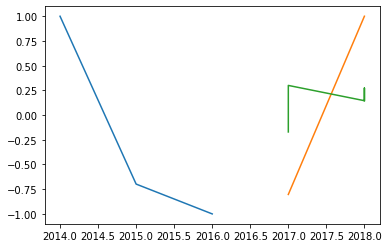

In [39]:
plt.plot(df[df['Company']==stock]['year'],df[df['Company']==stock]['NetIncomeLoss'])
plt.plot(df2[df2['Company']==stock]['year'],df2[df2['Company']==stock]['NetIncomeLoss'])
plt.plot(df2[df2['Company']==stock]['year'],df2[df2['Company']==stock]['y_pred'])

Text(0, 0.5, '')

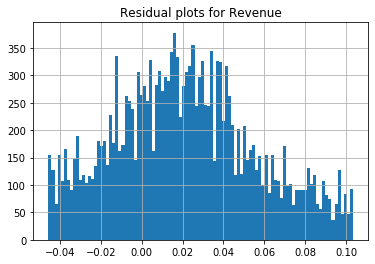

In [12]:
final_train.Revenue.hist(bins=100)
plt.title('Residual plots for Revenue')
plt.ylabel('')

Text(0, 0.5, '')

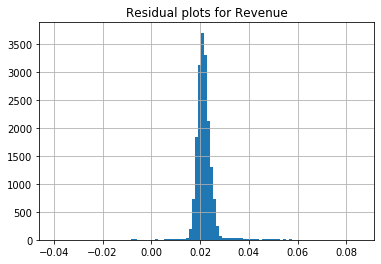

In [11]:
final_train.y_pred.hist(bins=100)
plt.title('Residual plots for Revenue')
plt.ylabel('')

Text(0, 0.5, '')

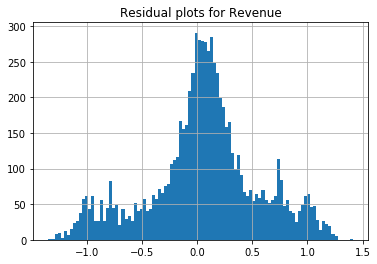

In [13]:
final_test.residuals.hist(bins=100)
plt.title('Residual plots for Revenue')
plt.ylabel('')

Text(0.5, 1.0, 'Histogram of Actual Revenue')

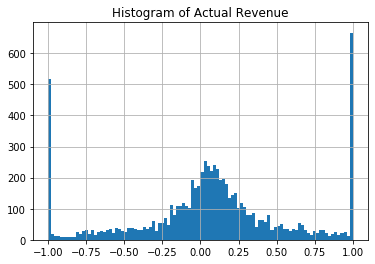

In [15]:
final_test.NetIncomeLoss.hist(bins=100)
plt.title('Histogram of Actual Revenue')

Text(0.5, 1.0, 'Histogram of Actual Revenue')

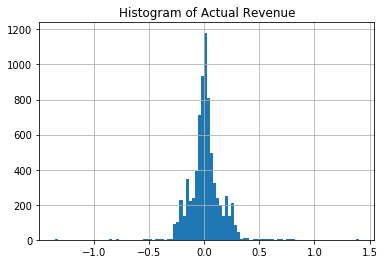

In [14]:
final_test.y_pred.hist(bins=100)
plt.title('Histogram of Actual Revenue')

In [1]:
test[test.Company=='MORN']

NameError: name 'test' is not defined

In [52]:
train.Company.unique()

array(['MORN', 'SBAC', 'UVE', 'GLUU', 'CPK', 'BGCP', 'ICUI', 'NFLX',
       'WCC', 'THG', 'AMKR', 'INSG', 'WRB', 'BG', 'ES', 'ALL', 'LAZ',
       'BRO', 'MHO', 'GPS', 'AWR', 'STAA', 'FAF', 'VIVO', 'CVS', 'INCY',
       'AMGN', 'CAI', 'WLK', 'HALL', 'BEN', 'NUAN', 'DPZ', 'MTD', 'EIX',
       'VSH', 'SAFT', 'CACC', 'OCN', 'MXL', 'VZ', 'UNH', 'FBHS', 'CME',
       'XLNX', 'IRBT', 'LPX', 'DLB', 'CENT', 'PDLI', 'CR', 'POOL', 'SANM',
       'MRO', 'CMPR', 'FSLR', 'OKE', 'AAWW', 'OII', 'ADS', 'WEX', 'CMI',
       'SLG', 'AEL', 'TSLA', 'AMT', 'AVA', 'KAMN', 'VTR', 'AMAT', 'PEG',
       'ATRI', 'YUM', 'JBL', 'CERN', 'GHL', 'CCK', 'ORBC', 'TXT', 'WSO',
       'BHE', 'ANTM', 'ATSG', 'STLD', 'FTR', 'ACCO', 'D', 'HE', 'MDU',
       'WEN', 'PSMT', 'FRPH', 'CTSH', 'DDS', 'RLGY', 'ALB', 'MTG', 'AMSF',
       'GHC', 'PCRX', 'UGI', 'FSS', 'AZO', 'INTU', 'CIEN', 'LPLA', 'MAR',
       'LVS', 'ANSS', 'OGE', 'TSN', 'HP', 'UNM', 'ADBE', 'CNC', 'ROCK',
       'T', 'NWE', 'CTL', 'LH', 'EVR', 'LII', 'KMI', 'WER